# This is the training script I run on the BitaHub server.

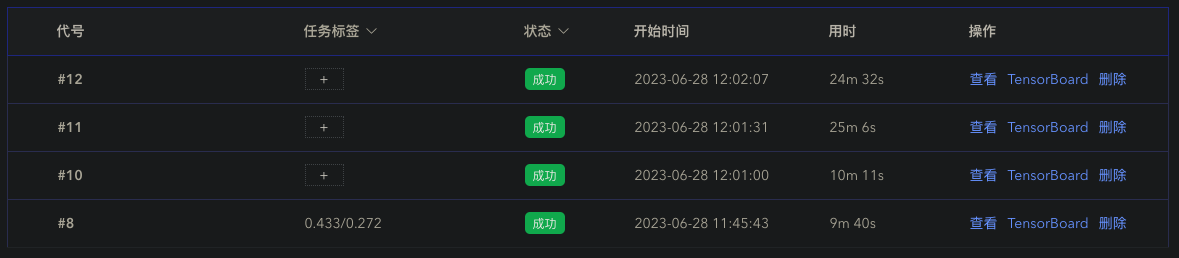

## The best result I got on FB15k-237:

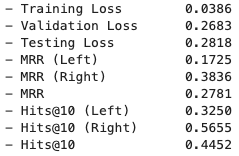

In [ ]:
import os
import platform
from packaging import version
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

# Utility functions defined in `utils.py`
from utils import (
    dict_to_namespace,
    read_toml,
    seed_everything,
    download_files,
    extract_file,
    move_content,
)

device_name = platform.node()
if device_name == 'nedsmac.local':
    DATA_DIR = 'data'
    CONFIG_DIR = 'configs'
    OUTPUT_DIR = 'output'
else:
    DATA_DIR = '/data/hasined'
    CONFIG_DIR = '/code/configs'
    OUTPUT_DIR = '/output'

config_files = sorted(os.listdir(CONFIG_DIR))
configs = {
    filename.split('.')[0]: dict_to_namespace(
        read_toml(os.path.join(CONFIG_DIR, filename))
    )
    for filename in config_files
    if filename.endswith('.toml')
}
DEBUG = False

print(f'TensorFlow version: {tf.version.VERSION}')
if not DEBUG:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    tf.get_logger().setLevel('ERROR')
physical_gpus = tf.config.list_physical_devices('GPU')
for gpu in physical_gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
logical_gpus = tf.config.list_logical_devices('GPU')
print(f'GPU: {logical_gpus}')

In [ ]:
class TripletDataset:
    def __init__(self):
        self.train_df: pd.DataFrame = None
        self.val_df: pd.DataFrame = None
        self.test_df: pd.DataFrame = None

        self.n_entities: int = None
        self.n_relations: int = None

        self.entity2id: dict[str, int] = None
        self.relation2id: dict[str, int] = None
        self.id2entity: dict[int, str] = None
        self.id2relation: dict[int, str] = None

        self.hrt_train: np.ndarray = None
        self.hrt_val: np.ndarray = None
        self.hrt_test: np.ndarray = None


def load_triplets(dataset: TripletDataset):
    def load_df(path):
        df = pd.read_csv(path, sep='\t', header=None)
        df.rename(columns={0: 'head', 1: 'relation', 2: 'tail'}, inplace=True)
        return df

    dataset.train_df = load_df(os.path.join(dataset.local_dir, 'train.txt'))
    dataset.val_df = load_df(os.path.join(dataset.local_dir, 'valid.txt'))
    dataset.test_df = load_df(os.path.join(dataset.local_dir, 'test.txt'))

    df = dataset.train_df
    dataset.n_entities = len(set(df['head']) | set(df['tail']))
    dataset.n_relations = len(set(df['relation']))

    return dataset.train_df, dataset.val_df, dataset.test_df

In [ ]:
class FB15k237(TripletDataset):
    url = 'https://download.microsoft.com/download/8/7/0/8700516A-AB3D-4850-B4BB-805C515AECE1/FB15K-237.2.zip'
    local_dir = os.path.join(DATA_DIR, 'FB15k-237')
    local_path = os.path.join(DATA_DIR, url.split('/')[-1])

    def __init__(self):
        if os.path.exists(self.local_dir):
            print(f'Using cached dataset at {self.local_dir}')
        else:
            download_files([self.url], DATA_DIR, rewrite=True)
            extract_file(self.local_path, self.local_dir, remove=True)
            move_content(
                os.path.join(self.local_dir, 'Release'), self.local_dir, remove=True
            )


fb15k237 = FB15k237()
load_triplets(fb15k237)[0].sample(3)

In [ ]:
class WN18RR(TripletDataset):
    url = 'https://github.com/TimDettmers/ConvE/raw/master/WN18RR.tar.gz'
    local_dir = os.path.join(DATA_DIR, 'WN18-RR')
    local_path = os.path.join(DATA_DIR, url.split('/')[-1])

    def __init__(self):
        if os.path.exists(self.local_dir):
            print(f'Using cached dataset at {self.local_dir}')
        else:
            download_files([self.url], DATA_DIR, rewrite=True)
            extract_file(self.local_path, self.local_dir, remove=True)


wn18rr = WN18RR()
load_triplets(wn18rr)[0].sample(3)

In [ ]:
def map_to_hrt(dataset: TripletDataset):
    # get mappings between entities and integer ids
    df = dataset.train_df
    dataset.entity2id = {e: i for i, e in enumerate(set(df['head']) | set(df['tail']))}
    dataset.id2entity = {v: k for k, v in dataset.entity2id.items()}
    # get mappings between relations and integer ids
    df = dataset.train_df
    dataset.relation2id = {r: i for i, r in enumerate(set(df['relation']))}
    dataset.id2relation = {v: k for k, v in dataset.relation2id.items()}

    # convert dataframes to numpy arrays of integer ids
    def df2hrt(df: pd.DataFrame):
        df = df.copy()
        df['head'] = df['head'].map(dataset.entity2id, na_action='ignore')
        df['relation'] = df['relation'].map(dataset.relation2id, na_action='ignore')
        df['tail'] = df['tail'].map(dataset.entity2id, na_action='ignore')
        # remove out-of-vocabulary items
        df.dropna(inplace=True)
        return np.asarray(df, dtype=np.int32)

    dataset.hrt_train = df2hrt(dataset.train_df)
    dataset.hrt_val = df2hrt(dataset.val_df)
    dataset.hrt_test = df2hrt(dataset.test_df)

    return (
        dataset.hrt_train,
        dataset.hrt_val,
        dataset.hrt_test,
        dataset.entity2id,
        dataset.relation2id,
    )


class BernNegSampler:
    def __init__(self, dataset: TripletDataset, n_neg_samples: int = 1):
        self.n_neg_samples = n_neg_samples
        self.n_entities = len(dataset.entity2id)
        self.n_relations = len(dataset.relation2id)

        # compute probabilities of corrupting head entity
        hrt = dataset.hrt_train
        hr_unique, hr_counts = np.unique(hrt[:, :2], axis=0, return_counts=True)
        rt_unique, rt_counts = np.unique(hrt[:, 1:], axis=0, return_counts=True)
        r_tph = np.asarray(
            [hr_counts[hr_unique[:, 1] == r].mean() for r in range(self.n_relations)],
            dtype=np.float32,
        )
        r_hpt = np.asarray(
            [rt_counts[rt_unique[:, 0] == r].mean() for r in range(self.n_relations)],
            dtype=np.float32,
        )
        self.head_corrupt_prob = r_tph / (r_tph + r_hpt)

    def __call__(self, pos: tf.Tensor):
        '''
        - Input: a batch of positive triplets (shape: [batch_size, 3])
        - Output: a batch of negative triplets (shape: [batch_size, n_neg_per_pos, 3])
        '''
        n_neg = tf.shape(pos)[0] * self.n_neg_samples
        neg_h = tf.repeat(pos[:, 0], self.n_neg_samples, axis=0)
        neg_r = tf.repeat(pos[:, 1], self.n_neg_samples, axis=0)
        neg_t = tf.repeat(pos[:, 2], self.n_neg_samples, axis=0)

        # corrupt head or tail
        pos_prob = tf.gather(self.head_corrupt_prob, pos[:, 1])
        neg_prob = tf.repeat(pos_prob, self.n_neg_samples, axis=0)
        mask = tf.random.uniform((n_neg,)) < neg_prob
        repl = tf.random.uniform((n_neg,), maxval=self.n_entities, dtype=tf.int32)
        neg_h = tf.where(mask, repl, neg_h)
        neg_t = tf.where(mask, neg_t, repl)

        neg = tf.stack([neg_h, neg_r, neg_t], axis=1)
        neg = tf.reshape(neg, (-1, self.n_neg_samples, 3))
        return neg


def create_ds(dataset: TripletDataset, n_batches, sampler):
    if len(dataset.hrt_train) % n_batches != 0:
        batch_size = len(dataset.hrt_train) // (n_batches - 1)
    else:
        batch_size = len(dataset.hrt_train) // n_batches

    def hrt2ds(hrt: np.ndarray):
        ds = tf.data.Dataset.from_tensor_slices(hrt)
        ds = ds.shuffle(len(hrt)).batch(batch_size)
        ds = ds.map(lambda x: {'pos': x, 'neg': sampler(x)})
        ds = ds.prefetch(tf.data.AUTOTUNE)
        return ds

    train_ds = hrt2ds(dataset.hrt_train)
    val_ds = hrt2ds(dataset.hrt_val)
    test_ds = hrt2ds(dataset.hrt_test)

    return train_ds, val_ds, test_ds

In [ ]:
from keras import Model
from keras.layers import Embedding


class TransE(Model):
    @staticmethod
    def embed_initializer(shape, dtype=None):
        limit = 6 / np.sqrt(shape[1])
        values = tf.random.uniform(shape, minval=-limit, maxval=limit, dtype=dtype)
        values = tf.math.l2_normalize(values, axis=1)
        return values

    def __init__(self, n_entities, n_relations, embed_dim, norm_ord=1, margin=1.0):
        super().__init__()
        self.n_entities = n_entities
        self.n_relations = n_relations
        self.embed_dim = embed_dim
        self.norm_ord = norm_ord
        self.margin = margin

        self.entity_embed = Embedding(
            n_entities,
            embed_dim,
            embeddings_initializer=self.embed_initializer,
            name='entity_embed',
        )
        self.relation_embed = Embedding(
            n_relations,
            embed_dim,
            embeddings_initializer=self.embed_initializer,
            name='relation_embed',
        )

        self.build((None, 3))
        self.compile()

    def call(self, hrt):
        '''
        Look up translating embeddings for head, relation, and tail.
        '''
        h, r, t = tf.unstack(hrt, axis=-1)
        h = self.entity_embed(h)
        r = self.relation_embed(r)
        t = self.entity_embed(t)
        return h, r, t

    def score(self, hrt):
        '''
        Compute the confidence score of a triple. (negative of dissimilarity/energy)
        '''
        h, r, t = self(hrt)
        return -tf.norm(h + r - t, ord=self.norm_ord, axis=-1)

    def margin_loss(self, pos, neg):
        '''
        Compute the averaged margin loss between each positive and its corresponding negatives.
        '''
        pos_score = tf.repeat(self.score(pos), tf.shape(neg)[1], axis=0)
        neg_score = tf.reshape(self.score(neg), (-1,))
        return tf.reduce_mean(tf.nn.relu(neg_score + self.margin - pos_score))

    def train_step(self, data):
        # normalize entity embeddings
        self.entity_embed.embeddings.assign(
            tf.math.l2_normalize(self.entity_embed.embeddings, axis=1)
        )

        with tf.GradientTape() as tape:
            loss = self.margin_loss(data['pos'], data['neg'])

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {'loss': loss}

    def test_step(self, data):
        return {'loss': self.margin_loss(data['pos'], data['neg'])}

    def fit(self, train_ds, val_ds, optimizer, n_epochs, **kwargs):
        self.optimizer = optimizer
        return super().fit(
            x=train_ds,
            y=None,
            validation_data=val_ds,
            epochs=n_epochs,
            **kwargs,
        )

In [ ]:
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger


def run_experiment(name, config):
    seed_everything(config.seed)

    # prepare dataset
    if config.dataset == 'FB15k-237':
        dataset = FB15k237()
    elif config.dataset == 'WN18-RR':
        dataset = WN18RR()
    else:
        raise NotImplementedError()
    load_triplets(dataset)
    map_to_hrt(dataset)

    # prepare negative sampler
    if config.neg_sampler == 'bernoulli':
        sampler = BernNegSampler(dataset, config.n_neg_samples)
    else:
        raise NotImplementedError()
    train_ds, val_ds, test_ds = create_ds(dataset, config.n_batches, sampler)

    # define model
    model = TransE(
        n_entities=dataset.n_entities,
        n_relations=dataset.n_relations,
        embed_dim=config.embed_dim,
        norm_ord=config.norm_ord,
        margin=config.margin,
    )

    # use checkpoint or train model
    ckpt_path = os.path.join(OUTPUT_DIR, name, 'checkpoint.keras')
    csv_path = os.path.join(OUTPUT_DIR, name, 'loss.csv')
    log_path = os.path.join(OUTPUT_DIR, name, 'logs')
    if os.path.exists(ckpt_path):
        print(f'Using pre-trained model at {ckpt_path}')
        model.load_weights(ckpt_path)
    else:
        print(f'Training model {name}')

        if config.optimizer == 'sgd':
            optimizer = SGD(learning_rate=config.learning_rate)
        elif config.optimizer == 'adam':
            optimizer = Adam(learning_rate=config.learning_rate)
        else:
            raise NotImplementedError()

        callbacks = [
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.1,
                patience=10,
                min_lr=1e-4,
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=80,
                restore_best_weights=True,
            ),
            CSVLogger(csv_path),
            TensorBoard(log_path),
        ]

        model.fit(
            train_ds=train_ds,
            val_ds=val_ds,
            optimizer=optimizer,
            n_epochs=config.n_epochs,
            callbacks=callbacks,
        )
        model.save_weights(ckpt_path)
        print(f'Saved model at {ckpt_path}')

    return model, dataset, train_ds, val_ds, test_ds


# Training
for name, config in configs.items():
    if DEBUG and name != 'DEBUG' or not DEBUG and name == 'DEBUG':
        continue
    print('=' * 80)
    print(f'Running experiment: {name}')
    display(vars(config))
    run_experiment(name, config)
print('=' * 80)

In [ ]:
import matplotlib.pyplot as plt

for name in configs.keys():
    if DEBUG and name != 'DEBUG' or not DEBUG and name == 'DEBUG':
        continue
    print('=' * 80)
    print(f'Plotting loss for {name}')
    csv_path = os.path.join(OUTPUT_DIR, name, 'loss.csv')
    if not os.path.exists(csv_path):
        print(f'No logs found for {name}, skipping')
        continue

    logs = pd.read_csv(csv_path)
    plt.figure(figsize=(6, 4))
    plt.plot(logs['loss'], color='b', linestyle='-', label='Train')
    plt.plot(logs['val_loss'], color='r', linestyle='-', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
print('=' * 80)

In [ ]:
class FalseNegFilter:
    def __init__(self, dataset: TripletDataset):
        triplet_df = pd.DataFrame(
            np.concatenate(
                [
                    dataset.hrt_train,
                    dataset.hrt_val,
                    dataset.hrt_test,
                ]
            ),
            columns=['h', 'r', 't'],
        )
        self.n_entities = dataset.n_entities
        # given r and t, look up all positive h
        self.head_lookup_df = triplet_df.groupby(['r', 't'])['h'].apply(set)
        self.tail_lookup_df = triplet_df.groupby(['r', 'h'])['t'].apply(set)

    def head_mask(self, h, r, t):
        mask = np.zeros(self.n_entities, dtype=bool)
        if (r, t) in self.head_lookup_df:
            indices = list(self.head_lookup_df[r, t] - {h})
            mask[indices] = True
        return mask

    def tail_mask(self, h, r, t):
        mask = np.zeros(self.n_entities, dtype=bool)
        if (r, h) in self.tail_lookup_df:
            indices = list(self.tail_lookup_df[r, h] - {t})
            mask[indices] = True
        return mask

In [ ]:
@tf.function
def predict_head_scores(model, r, t):
    '''
    Predict the scores of all possible heads given a relation and a tail.
    '''
    r = tf.repeat(r, model.n_entities)
    t = tf.repeat(t, model.n_entities)
    h = tf.range(model.n_entities)
    scores = model.score(tf.stack([h, r, t], axis=1))
    return scores


@tf.function
def predict_tail_scores(model, h, r):
    '''
    Predict the scores of all possible tails given a head and a relation.
    '''
    h = tf.repeat(h, model.n_entities)
    r = tf.repeat(r, model.n_entities)
    t = tf.range(model.n_entities)
    scores = model.score(tf.stack([h, r, t], axis=1))
    return scores


def compute_metrics(model, k, hrt, neg_filter: FalseNegFilter = None):
    '''
    Compute MRR and Hits@k.
    '''

    def func(i):
        h, r, t = hrt[i, 0], hrt[i, 1], hrt[i, 2]
        head_scores = predict_head_scores(model, r, t)
        tail_scores = predict_tail_scores(model, h, r)

        if neg_filter is not None:
            head_mask = neg_filter.head_mask(h, r, t)
            tail_mask = neg_filter.tail_mask(h, r, t)
            head_scores = np.where(head_mask, -np.inf, head_scores)
            tail_scores = np.where(tail_mask, -np.inf, tail_scores)

        rank_left = np.sum(head_scores > head_scores[h])
        rank_right = np.sum(tail_scores > tail_scores[t])
        rr_left = 1 / (rank_left + 1)
        rr_right = 1 / (rank_right + 1)
        hits_left = rank_left < k
        hits_right = rank_right < k
        return rr_left, rr_right, hits_left, hits_right

    mrr_left, mrr_right, hits_left, hits_right = zip(
        *[func(i) for i in tqdm(range(len(hrt)), leave=False)]
    )
    return (
        np.mean(mrr_left),
        np.mean(mrr_right),
        np.mean(hits_left),
        np.mean(hits_right),
    )


# Evaluation
for name, config in configs.items():
    if DEBUG and name != 'DEBUG' or not DEBUG and name == 'DEBUG':
        continue

    print('=' * 80)
    print(f'Evaluating model {name}')
    ckpt_path = os.path.join(OUTPUT_DIR, name, 'checkpoint.keras')
    if not os.path.exists(ckpt_path):
        print(f'No checkpoint found for model {name}, skipping')
        continue

    model, dataset, train_ds, val_ds, test_ds = run_experiment(name, config)
    results = {}
    results['Training Loss'] = model.evaluate(train_ds, verbose=0)
    results['Validation Loss'] = model.evaluate(val_ds, verbose=0)
    results['Testing Loss'] = model.evaluate(test_ds, verbose=0)
    metrics = compute_metrics(
        model, k=10, hrt=dataset.hrt_test, neg_filter=FalseNegFilter(dataset)
    )
    results['MRR (Left)'] = metrics[0]
    results['MRR (Right)'] = metrics[1]
    results['MRR'] = (metrics[0] + metrics[1]) / 2
    results['Hits@10 (Left)'] = metrics[2]
    results['Hits@10 (Right)'] = metrics[3]
    results['Hits@10'] = (metrics[2] + metrics[3]) / 2
    for k, v in results.items():
        print(f'- {k:<20} {v:.4f}')
print('=' * 80)